#Laboratorio 2
*Realizado por: Guillermo Mármol, Enrique Ramos e Ignacio Regidor*

## Exploración y preprocesamiento
Primero, se importan las librerias necesarias

In [ ]:
!pip install transformers
!pip install --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 29.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [ ]:
from keras.datasets import reuters
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import keras
from keras import ops
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer,Input, Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dense, LayerNormalization, Dropout

Se carga el dataset de **reuters**.

In [ ]:
num_words=10000
# Cargar el conjunto de datos limitando el número de palabras a 10,000
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Exploración básica del conjunto de datos.

In [ ]:
# Exploración básica del conjunto de datos
# Vamos a ver cómo lucen los primeros datos

# Obteniendo el índice de palabras
word_index = reuters.get_word_index()
# Invirtiendo el índice de palabras para obtener un mapeo de índices a palabras
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Decodificando el primer texto de entrenamiento
# Las indices 0, 1, y 2 son reservados para "padding", "start of sequence", y "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i-3, '?') for i in train_data[0]])
print(f"Primer texto de entrenamiento (codificado): {train_data[0]}")
print(f"Primer texto de entrenamiento (decodificado): {decoded_newswire}")
print(f"Clasificación del primer texto de entrenamiento: {train_labels[0]}")
print(f"Etiqueta del primer texto de entrenamiento: {train_labels[0]}")

print(f"\nNúmero de ejemplos de entrenamiento:", len(train_data))
print("Número de ejemplos de prueba:", len(test_data))

num_classes = np.max(train_labels) + 1  # Las etiquetas comienzan en 0
print("Número de clases:", num_classes)

550378/550378 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Primer texto de entrenamiento (codificado): [1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
Primer texto de entrenamiento (decodificado): ? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3
Clasificación del primer texto de entrenamiento: 3
Etiqueta del primer texto de entrenamiento: 3

Número de ejempl

Se entenará un modelo Transformer con 8962 noticias, las cuales se clasificarán en 46 categorías. Se validará el modelo con otras 2246 noticias.

In [ ]:
# Obtener los nombres de las etiquetas/categorías
index_names = reuters.get_word_index(path="reuters_word_index.json")

# Creamos una lista de tuplas que contengan el índice de la categoría y su nombre
index_names_list = [(index, name) for name, index in index_names.items()]

# Convertimos la lista de tuplas en un DataFrame
index_names_df = pd.DataFrame(index_names_list, columns=['Category Index', 'Category Name'])

# Ordenamos el DataFrame por el índice de la categoría
index_names_df.sort_values('Category Index', inplace=True)

# Establecer "Indice de Tema" como el índice del DataFrame
index_names_df = index_names_df.set_index('Category Index')

print(f"Número de palabras total: {len(index_names_df)}")
index_names_df.head(15)

Número de palabras total: 30979


,Category Name
Category Index,
1,the
2,of
3,to
4,in
5,said
6,and
7,a
8,mln
9,3


Se obtienen las distintas categorías de noticias con sus correspondientes índices.

In [ ]:
# Obtener los nombres de las etiquetas/categorías
label_names = reuters.get_label_names()  # Asumiendo que este método está disponible

# Crear un DataFrame para visualizar las etiquetas
label_names_df = pd.DataFrame({
    'Indice de Tema': range(len(label_names)),
    'Tema': label_names
})

# Establecer "Indice de Tema" como el índice del DataFrame
label_names_df = label_names_df.set_index('Indice de Tema')

# Mostrar las primeras filas del DataFrame
result = pd.concat([label_names_df.head(), label_names_df.tail()])
result

,Tema
Indice de Tema,
0,cocoa
1,grain
2,veg-oil
3,earn
4,acq
41,gas
42,silver
43,wpi
44,hog



Se va a analizar la distribucion de las noticias en funcion de en que categoria caen.

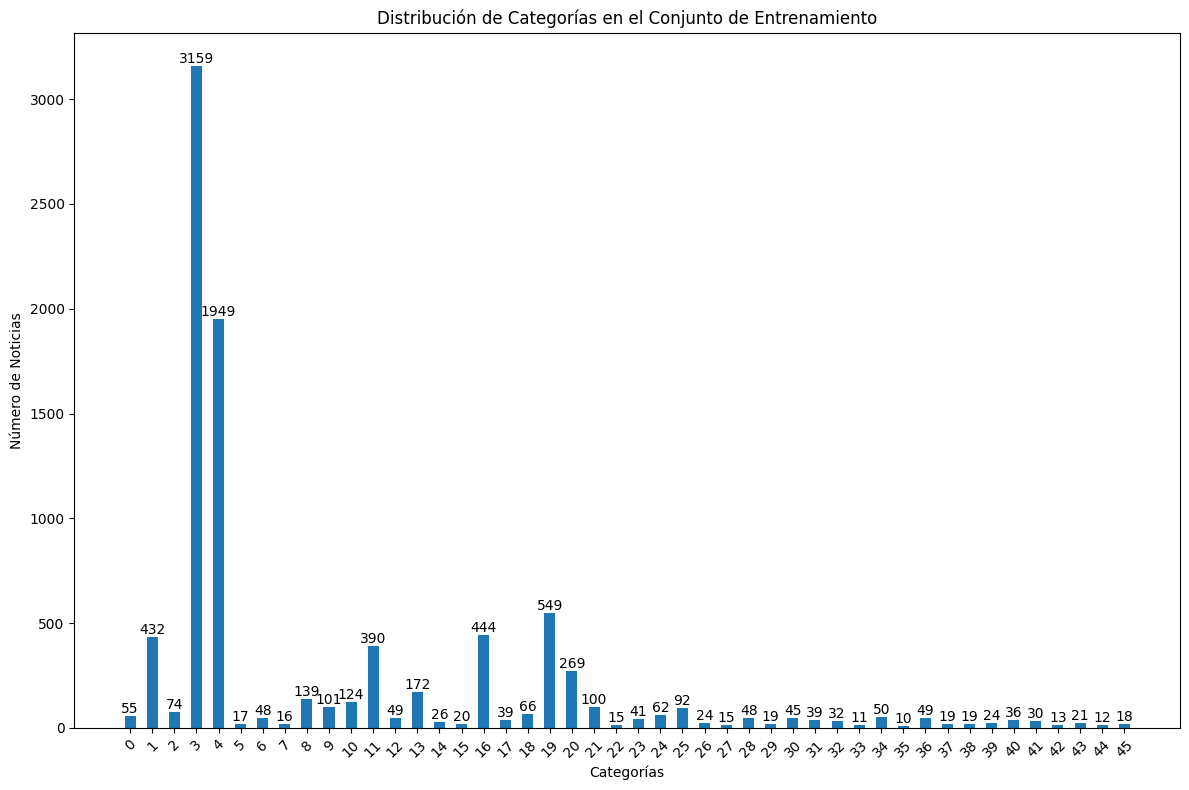

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(12, 8))
# Ajusta el ancho de las barras con el parámetro `width`
bars = plt.bar(unique, counts, width=0.5)  # Ajusta el valor de width según sea necesario
plt.title('Distribución de Categorías en el Conjunto de Entrenamiento')
plt.xlabel('Categorías')
plt.ylabel('Número de Noticias')

# Ajustando las etiquetas del eje x para evitar solapamientos
plt.xticks(unique, rotation=45)  # Rotar las etiquetas para mejor visualización

# Añadiendo las anotaciones en cada barra
for bar in bars:
    yval = bar.get_height()
    # Ajusta la posición y el alineamiento del texto para evitar solapamientos
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center')

plt.tight_layout()  # Ajusta automáticamente los parámetros del subplot para que la figura encaje en el área
plt.show()

Es evidente por la grafica que la categoria mas representativa que es 'earn' con 3159 noticias que caen en esta categoria. Esta categoria vemos que esta sobrerepresentada.
A continuacion se grafica la distribucion de la longitud de las noticias.


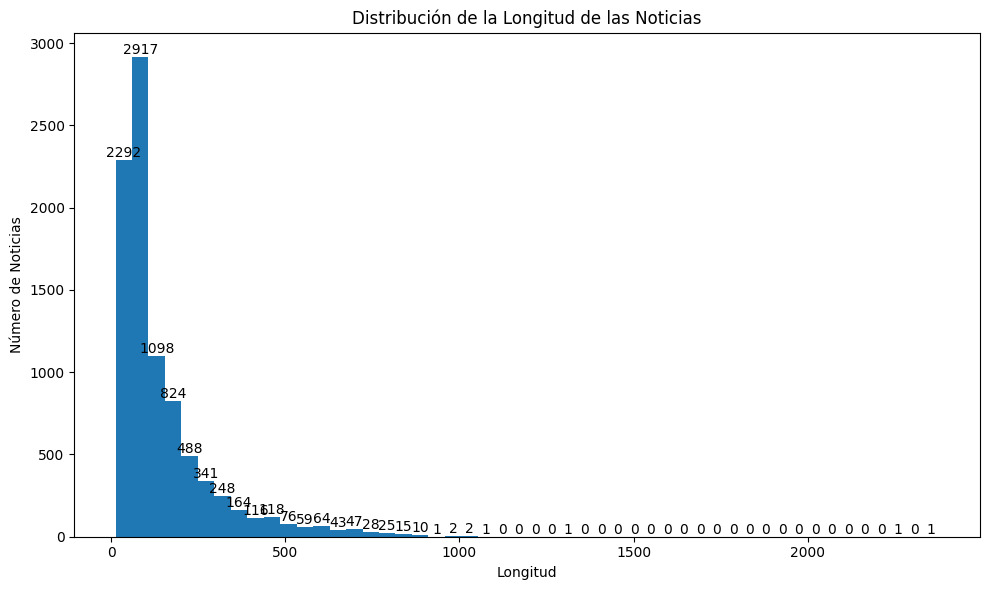

In [ ]:
# Analizar la longitud de las noticias
lengths = [len(news) for news in train_data]

plt.figure(figsize=(10, 6))
# Almacenar los objetos retornados por hist para anotar las alturas de las barras
n, bins, patches = plt.hist(lengths, bins=50)
plt.title('Distribución de la Longitud de las Noticias')
plt.xlabel('Longitud')
plt.ylabel('Número de Noticias')

# Añadiendo anotaciones en las barras
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, n[i], str(int(n[i])), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Se observa que a partir de las 1000 palabras podemos descartarlas. De todas formas se va a hacer un diagrama de caja para ver a partir de que punto se consideran outliers.

Longitud promedio de las noticias: 145.54
Desviación estándar: 145.81
Máxima longitud de noticia: 2376
Mínima longitud de noticia: 13


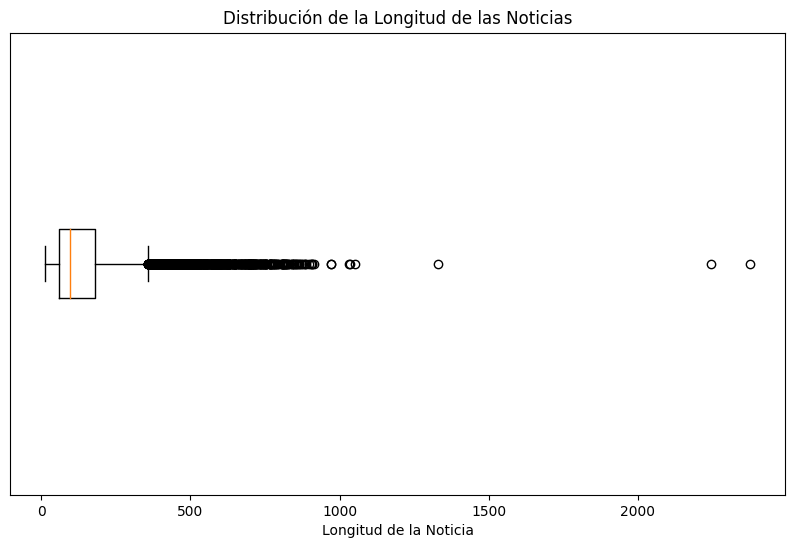

In [ ]:
print(f"Longitud promedio de las noticias: {np.mean(lengths):.2f}")
print(f"Desviación estándar: {np.std(lengths):.2f}")
print(f"Máxima longitud de noticia: {np.max(lengths)}")
print(f"Mínima longitud de noticia: {np.min(lengths)}")
# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(lengths, vert=False)
plt.title('Distribución de la Longitud de las Noticias')
plt.xlabel('Longitud de la Noticia')
plt.yticks([])  # Esconder etiquetas del eje Y para mejorar claridad
plt.show()

Del diagrama de caja queda claro que a partir de las 357 tokens se consideran outliers por lo tanto vamos a limitar la longutud de las noticias a 357 tokens para facilitar el entrenamiento. En este caso un 8.08% de las noticias son outliers.

In [ ]:
# Calculando Q1, Q3 y IQR
Q1 = np.percentile(lengths, 25)
Q3 = np.percentile(lengths, 75)
IQR = Q3 - Q1
# Calculando el bigote superior (el valor máximo antes de considerar outliers)
bigote_superior = Q3 + 1.5 * IQR
outliers = sum(lengths>bigote_superior)
perc_outliers = outliers/len(lengths)*100
print(f"El límite de los outliers es: {bigote_superior}.")
print(f"Hay {outliers} outliers. Esto supone un {perc_outliers:.2f}% del total de noticias.")

El límite de los outliers es: 357.5.
Hay 726 outliers. Esto supone un 8.08% del total de noticias.


Una vez comprendida la estructura del data set y sabiendo que Reuters ya esta tokenizado y ademas estan en un formato categorical_crossentropy

## Modelo Transformer

###Padding

In [ ]:
num_words = 10000
maxlen = 357  # Define la longitud máxima de las secuencias siguiendo el boxplot

# Padding de las secuencias para que todas tengan la misma longitud
x_train = pad_sequences(train_data, maxlen=maxlen)
x_test = pad_sequences(test_data, maxlen=maxlen)

# One-hot encoding de las etiquetas
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

x_train

array([[  0,   0,   0, ...,  15,  17,  12],
       [  0,   0,   0, ..., 505,  17,  12],
       [  0,   0,   0, ...,  11,  17,  12],
       ...,
       [  0,   0,   0, ..., 407,  17,  12],
       [  0,   0,   0, ..., 364,  17,  12],
       [  0,   0,   0, ..., 113,  17,  12]], dtype=int32)

### Bloque Transformer y Embedding

Se definen varias clases que conjuntamente definirán el modelo Transformer.

**TransformerBlock**

La clase TransformerBlock define un bloque básico de un Transformer, que incluye los siguientes elementos:

**MultiHeadAttention:** Esta capa realiza la atención de múltiples cabezas sobre las entradas. La atención de múltiples cabezas permite que el modelo preste atención a diferentes partes de la entrada simultáneamente, lo que es crucial para capturar las relaciones contextuales en los datos.

**Feed Forward Network (FFN):** Después de la capa de atención, los datos se pasan a través de una red feed-forward que consta de dos capas densas. La primera capa densa tiene una función de activación ReLU y una dimensión definida por ff_dim. La segunda capa densa devuelve los datos a la dimensión original de la incrustación (embed_dim).

**LayerNormalization:** Se utilizan dos capas de normalización, una después de sumar la salida de la atención a las entradas (residual connection) y otra después de sumar la salida de la red feed-forward a la salida intermedia del bloque (otra conexión residual).

**Dropout:** Se aplica la regularización dropout después de la atención y después de la red feed-forward para prevenir el sobreajuste.

La función **call** define cómo fluyen los datos a través de este bloque: primero a través de la atención de múltiples cabezas, luego se suman los resultados a las entradas (conexión residual), seguido de la normalización de la capa, luego a través de la red feed-forward, otra operación de suma (conexión residual) y finalmente otra normalización de capa.

**TokenAndPositionEmbedding**

La clase TokenAndPositionEmbedding se encarga de generar las incrustaciones (embeddings) tanto de los tokens como de sus posiciones dentro de una secuencia:

**token_emb**: Esta capa de incrustación transforma los índices de tokens en vectores densos de tamaño embed_dim. Cada token de entrada se convierte en un vector de alta dimensión que captura información semántica.

**pos_emb:** Similar a token_emb, pero esta capa de incrustación se utiliza para codificar la posición de cada token en la secuencia. Esto es esencial en los Transformers, ya que no utilizan recurrencia o convoluciones y por lo tanto necesitan una forma de incorporar la información de la posición de los tokens en la secuencia.

La función **call** de esta clase toma como entrada una secuencia de tokens, los transforma en incrustaciones de tokens usando token_emb, genera incrustaciones de posición para cada posición en la secuencia y suma estas dos incrustaciones para producir la incrustación final que tiene en cuenta tanto el token como su posición en la secuencia.

**Aplicación en un Transformer**

Estas clases se utilizan para construir un modelo Transformer, donde TokenAndPositionEmbedding se utiliza al principio para convertir la entrada(tokens) en vectores que contienen información semántica y posicional. Luego, estas incrustaciones se pasan a través de uno o más TransformerBlock, donde el modelo aprende a prestar atención a diferentes partes de la entrada y a refinar las representaciones de los tokens en función del contexto. Juntas, estas clases permiten la construcción de un modelo Transformer que puede ser entrenado para realizar diversas tareas de NLP, como clasificación de texto, traducción automática, generación de texto, etc.

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = ops.shape(x)[-1]
        positions = ops.arange(start=0, stop=maxlen, step=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

### Construcción Modelo
A continuación, se construye el modelo de red neuronal utilizando la arquitectura Transformer para el procesamiento y clasificación de las secuencias de texto. Se define la dimensión del embedding para cada token (64), el número de cabezas de atención en el mecanismo de atención (2), y el tamaño de la capa oculta en la red feed forward interna del bloque Transformer (32).
El modelo comienza con con una capa de entrada y una de embedding que agrega información de posición. Sigue un bloque Transformer que aplica atención multi-cabeza y una red feed forward. La secuencia procesada es luego comprimida, regularizada mediante Dropout, y pasada por capas densas con activación ReLU y una softmax de salida para la clasificación final en 46 categorías.



In [ ]:
embed_dim = 64
num_heads = 2
ff_dim = 32

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, num_words, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(46, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 357)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, 357, 64)             │         662,848 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block_1                  │ (None, 357, 64)             │          37,664 │
│ (TransformerBlock)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 46)                  │             966 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 702,778 (2.68 MB)

 Trainable params: 702,778 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento
Finalmente, se prepara y entrena el modelo de clasificación de texto previamente descrito. Primero, se compila el modelo utilizando el optimizador Adam y la función de pérdida Categorical_Crossentropy (debido a que las clases están representadas por números enteros y no one-hot encoding), con la precisión como métrica de evaluación. Luego, se inicia el entrenamiento del modelo con los datos de entrenamiento (x_train, y_train), con un batch size de  32 y durante 10 epochs. Durante el entrenamiento, también se evalúa el rendimiento del modelo en un conjunto de datos de test (x_test, y_test) para monitorear cómo el modelo generaliza a datos no vistos anteriormente.


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test)
)

Epoch 1/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 186s 620ms/step - accuracy: 0.3888 - loss: 2.5698 - val_accuracy: 0.6273 - val_loss: 1.5814
Epoch 2/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 197s 604ms/step - accuracy: 0.6754 - loss: 1.3417 - val_accuracy: 0.7449 - val_loss: 1.0906
Epoch 3/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 186s 546ms/step - accuracy: 0.7790 - loss: 0.9480 - val_accuracy: 0.7778 - val_loss: 0.9875
Epoch 4/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 190s 503ms/step - accuracy: 0.8387 - loss: 0.6867 - val_accuracy: 0.7898 - val_loss: 0.9738
Epoch 5/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 149s 528ms/step - accuracy: 0.8707 - loss: 0.5325 - val_accuracy: 0.7925 - val_loss: 0.9974
Epoch 6/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 196s 506ms/step - accuracy: 0.8978 - loss: 0.4341 - val_accuracy: 0.8050 - val_loss: 1.0060
Epoch 7/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 201s 501ms/step - accuracy: 0.9163 - loss: 0.3379 - val_accuracy: 0.7907 - val_loss: 1.1213
Epoch 8/10
281/281 ━━━━━━━━━━━━━━━━━━━━ 142s 506ms/step - accuracy: 0.9235 -

### Resultados
Ahora, se realiza una representación gráfica de la evolución de la pérdida y la precisión de un modelo a lo largo del tiempo, durante su entrenamiento y validación. Esto permite evaluar visualmente cómo el modelo mejora su rendimiento (o no) a medida que se entrena, facilitando la identificación de problemas como el sobreajuste o el bajo ajuste.

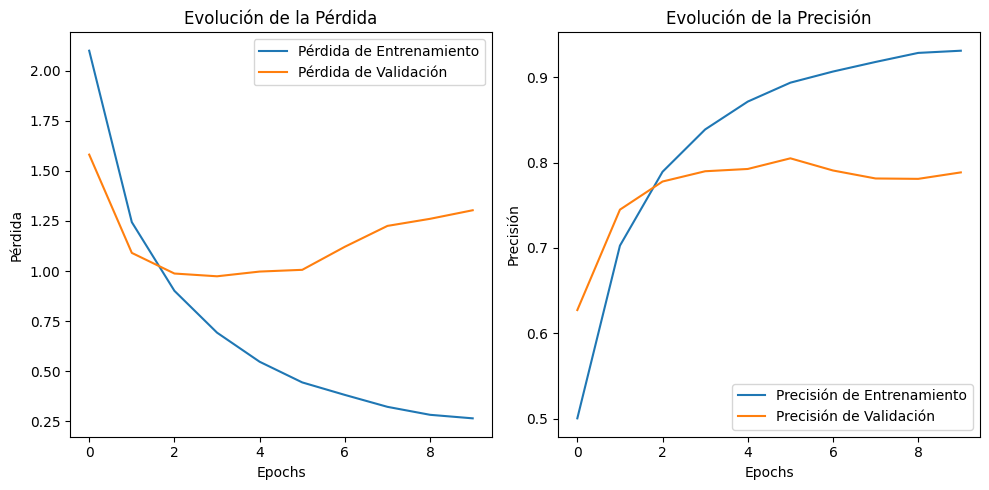

In [ ]:
# Graficar la pérdida
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, posición 1
plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()

# Graficar la precisión
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, posición 2
plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()

plt.tight_layout()
plt.show()


## Trabajo a Futuro

Evitar el sobreajuste con un callback que guarde los parámetros de la época en la que el Transformer tenía un menor error en los datos de validación. En este caso, se podría parar el entrenamiento con 3 épocas.

Se pueden aplicar técnicas para balancear la distribución de las clases para hacerlas más uniformes, con técnicas de OverSampling.

Además, el ratio de noticias entre la longitud promedio de tokens de cada una de ellas es menor que 1500, por lo que podría ser más óptimo y eficiente un modelo de bolsa de palabras aunque no tenga en cuenta la secuencialidad.